In [1]:
%matplotlib inline

morange = u'#ff7f0e'
mblue = u'#1f77b4'
mgreen = u'#2ca02c'
mred = u'#d62728'
mpurple = u'#9467bd'

In [2]:
from cosmodc2.sdss_colors import load_umachine_processed_sdss_catalog
sdss = load_umachine_processed_sdss_catalog()
print(sdss.keys())

/Users/aphearin/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['ra', 'dec', 'z', 'sm', 'ssfr', 'nd', 'restframe_extincted_sdss_abs_magr', 'restframe_extincted_sdss_gr', 'restframe_extincted_sdss_ri', 'size_kpc', 'dr7_PhotoObj_Table_ID', 'sfr_percentile_fixed_sm', 'gr_percentile_fixed_magr']


In [4]:
import os
from astropy.table import Table

#  MDPL2-based mock
dirname = "/Users/aphearin/work/random/ARCHIVES/2018/March2018/0331"
basename = "cutmock_1e9.hdf5"
fname = os.path.join(dirname, basename)
mock = Table.read(fname, path='data')
mock.Lbox = 500.


## Assign black hole mass

In [5]:
from cosmodc2.black_hole_modeling import monte_carlo_black_hole_mass

mock['bt'] = np.random.rand(len(mock))
mock['bulge_mass'] = mock['obs_sm']*mock['bt']
mock['bh_mass'] = monte_carlo_black_hole_mass(mock['bulge_mass'])

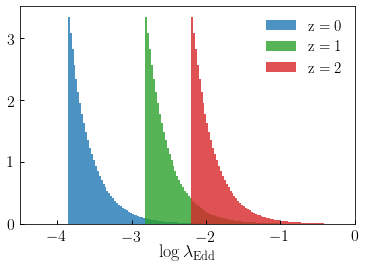

In [7]:
from cosmodc2.black_hole_modeling import monte_carlo_bh_acc_rate
eddington_ratio_z0, accretion_rate_z0 = monte_carlo_bh_acc_rate(
    0., mock['bh_mass'], mock['sfr_percentile'])
eddington_ratio_z1, accretion_rate_z1 = monte_carlo_bh_acc_rate(
    1., mock['bh_mass'], mock['sfr_percentile'])
eddington_ratio_z2, accretion_rate_z2 = monte_carlo_bh_acc_rate(
    2., mock['bh_mass'], mock['sfr_percentile'])

fig, ax = plt.subplots(1, 1)

__=ax.hist(np.log10(eddington_ratio_z0), bins=100, normed=True, 
           alpha=0.8, color=mblue, label=r'${\rm z=0}$')
__=ax.hist(np.log10(eddington_ratio_z1), bins=100, normed=True, 
           alpha=0.8, color=mgreen, label=r'${\rm z=1}$')
__=ax.hist(np.log10(eddington_ratio_z2), bins=100, normed=True, 
           alpha=0.8, color=mred, label=r'${\rm z=2}$')

legend = ax.legend()
xlabel = ax.set_xlabel(r'${\rm \log \lambda_{Edd}}$')
xlim = ax.set_xlim(-4.5, 0)

figname = 'black_hole_eddington_ratios_redshift_evolution.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel], bbox_inches='tight')

In [8]:
from cosmodc2.black_hole_modeling import monte_carlo_bh_acc_rate

redshift = 0.
eddington_ratio, accretion_rate = monte_carlo_bh_acc_rate(
    redshift, mock['bh_mass'], mock['sfr_percentile'])
mock['eddington_ratio'] = eddington_ratio
mock['bh_acc_rate'] = accretion_rate

### Plot redshift-dependence

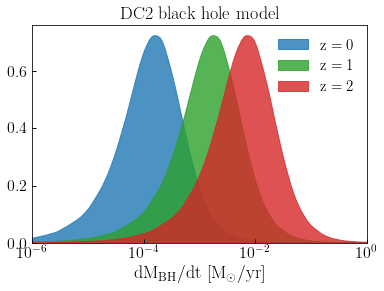

In [17]:
sm_mask = mock['obs_sm'] > 10**10
sm_mask *= mock['obs_sm'] < 10**10.5
eddington_ratio_z0, accretion_rate_z0 = monte_carlo_bh_acc_rate(
    0., mock['bh_mass'], mock['sfr_percentile'])
eddington_ratio_z1, accretion_rate_z1 = monte_carlo_bh_acc_rate(
    1., mock['bh_mass'], mock['sfr_percentile'])
eddington_ratio_z2, accretion_rate_z2 = monte_carlo_bh_acc_rate(
    2., mock['bh_mass'], mock['sfr_percentile'])

fig, ax = plt.subplots(1, 1)

# __=ax.hist(np.log10(accretion_rate_z0[sm_mask]), bins=100, normed=True, 
#            alpha=0.8, label=r'${\rm z=0}$', color=mblue)
# __=ax.hist(np.log10(accretion_rate_z1[sm_mask]), bins=100, normed=True, 
#            alpha=0.8, label=r'${\rm z=1}$', color=mgreen)
# __=ax.hist(np.log10(accretion_rate_z2[sm_mask]), bins=100, normed=True, 
#            alpha=0.8, label=r'${\rm z=2}$', color=mred)

from scipy.stats import gaussian_kde
kde_z0 = gaussian_kde(np.log10(accretion_rate_z0[sm_mask]))
kde_z1 = gaussian_kde(np.log10(accretion_rate_z1[sm_mask]))
kde_z2 = gaussian_kde(np.log10(accretion_rate_z2[sm_mask]))

x = np.linspace(-7, 0, 150)
pdf_z0 = kde_z0.evaluate(x)
pdf_z1 = kde_z1.evaluate(x)
pdf_z2 = kde_z2.evaluate(x)

__=ax.fill(x, pdf_z0, alpha=0.8, label=r'${\rm z=0}$', color=mblue)
__=ax.fill(x, pdf_z1, alpha=0.8, label=r'${\rm z=1}$', color=mgreen)
__=ax.fill(x, pdf_z2, alpha=0.8, label=r'${\rm z=2}$', color=mred)


# title = ax.set_title(r'${\rm M_{\ast}\approx10^{10.5}M_{\odot}$}')
title = ax.set_title(r'${\rm DC2\ black\ hole\ model}$')
xlabel = ax.set_xlabel(r'${\rm dM_{BH}/dt\ [M_{\odot}/yr]}$')
legend = ax.legend()

xlim = ax.set_xlim(-6, 0)
ylim = ax.set_ylim(ymin=0)
__=ax.set_xticks((-6, -4, -2, 0))
xticklabels = (r'$10^{-6}$', r'$10^{-4}$', r'$10^{-2}$', r'$10^{0}$')
__=ax.set_xticklabels(xticklabels)

figname = 'black_hole_accretion_rates_v4_redshift_evolution.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel], bbox_inches='tight')

### Plot color-dependence

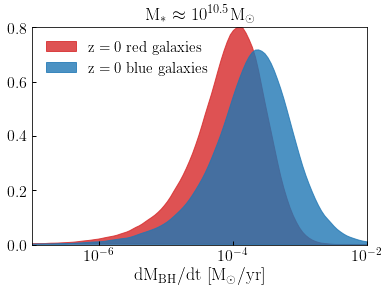

In [20]:
sm_mask = mock['obs_sm'] > 10**10
sm_mask *= mock['obs_sm'] < 10**10.5
median_sfr = np.median(mock['obs_sfr'][sm_mask])

sfr_mask1 = mock['obs_sfr'] < median_sfr
mask1 = sm_mask & sfr_mask1
sfr_mask2 = mock['obs_sfr'] > median_sfr
mask2 = sm_mask & sfr_mask2

eddington_ratio_z0, accretion_rate_z0 = monte_carlo_bh_acc_rate(
    0., mock['bh_mass'], mock['sfr_percentile'])

fig, ax = plt.subplots(1, 1)

# __=ax.hist(np.log10(accretion_rate_z0[mask1]), bins=100, normed=True, 
#            alpha=0.8, label=r'${\rm z=0\ red\ galaxies}$', color=mred)
# __=ax.hist(np.log10(accretion_rate_z0[mask2]), bins=100, normed=True, 
#            alpha=0.8, label=r'${\rm z=0\ blue\ galaxies}$', color=mblue)

from scipy.stats import gaussian_kde
kde_red = gaussian_kde(np.log10(accretion_rate_z0[mask1]))
kde_blue = gaussian_kde(np.log10(accretion_rate_z0[mask2]))

x = np.linspace(-7, 0, 150)
pdf_red = kde_red.evaluate(x)
pdf_blue = kde_blue.evaluate(x)

__=ax.fill(x, pdf_red, alpha=0.8, label=r'${\rm z=0\ red\ galaxies}$', color=mred)
__=ax.fill(x, pdf_blue, alpha=0.8, label=r'${\rm z=0\ blue\ galaxies}$', color=mblue)

ylim = ax.set_ylim(0, 0.8)
title = ax.set_title(r'${\rm M_{\ast}\approx10^{10.5}M_{\odot}$}')
xlabel = ax.set_xlabel(r'${\rm dM_{BH}/dt\ [M_{\odot}/yr]}$')
legend = ax.legend(loc='upper left')

xlim = ax.set_xlim(-7, -2)
__=ax.set_xticks((-6, -4, -2))
xticklabels = (r'$10^{-6}$', r'$10^{-4}$', r'$10^{-2}$')
__=ax.set_xticklabels(xticklabels)

figname = 'black_hole_accretion_rates_v4_sfr_dependence.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel], bbox_inches='tight')

### Plot mass-dependence

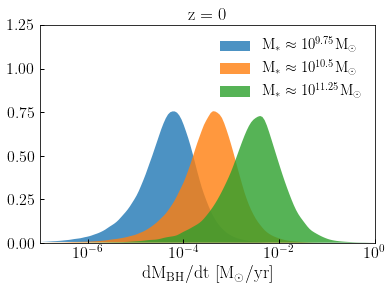

In [22]:
mask1 = (mock['obs_sm'] > 10**9.75) & (mock['obs_sm'] < 10**10)
mask2 = (mock['obs_sm'] > 10**10.5) & (mock['obs_sm'] < 10**10.75)
mask3 = (mock['obs_sm'] > 10**11.25) #& (mock['obs_sm'] < 10**10)

eddington_ratio_z0, accretion_rate_z0 = monte_carlo_bh_acc_rate(
    0., mock['bh_mass'], mock['sfr_percentile'])

fig, ax = plt.subplots(1, 1)

# __=ax.hist(np.log10(accretion_rate_z0[mask1]), bins=100, normed=True, 
#            alpha=0.8, label=r'${\rm M_{\ast}\approx10^{9.75}M_{\odot}}$')
# __=ax.hist(np.log10(accretion_rate_z0[mask2]), bins=100, normed=True, 
#            alpha=0.8, label=r'${\rm M_{\ast}\approx10^{10.5}M_{\odot}}$')
# __=ax.hist(np.log10(accretion_rate_z0[mask3]), bins=100, normed=True, 
#            alpha=0.8, label=r'${\rm M_{\ast}\approx10^{11.25}M_{\odot}}$')

from scipy.stats import gaussian_kde
kde_red = gaussian_kde(np.log10(accretion_rate_z0[mask1]))
kde_blue = gaussian_kde(np.log10(accretion_rate_z0[mask2]))
kde_orange = gaussian_kde(np.log10(accretion_rate_z0[mask3]))

x = np.linspace(-7, 0, 150)
pdf_red = kde_red.evaluate(x)
pdf_blue = kde_blue.evaluate(x)
pdf_orange = kde_orange.evaluate(x)

__=ax.fill(x, pdf_red, alpha=0.8, label=r'${\rm M_{\ast}\approx10^{9.75}M_{\odot}}$')
__=ax.fill(x, pdf_blue, alpha=0.8, label=r'${\rm M_{\ast}\approx10^{10.5}M_{\odot}}$')
__=ax.fill(x, pdf_orange, alpha=0.8, label=r'${\rm M_{\ast}\approx10^{11.25}M_{\odot}}$')

title = ax.set_title(r'${\rm z=0}$')
xlabel = ax.set_xlabel(r'${\rm dM_{BH}/dt\ [M_{\odot}/yr]}$')
legend = ax.legend()

ylim = ax.set_ylim(0, 1.25)
xlim = ax.set_xlim(-7, 0)
__=ax.set_xticks((-6, -4, -2, 0))
xticklabels = (r'$10^{-6}$', r'$10^{-4}$', r'$10^{-2}$', r'$10^{0}$')
__=ax.set_xticklabels(xticklabels)

figname = 'black_hole_accretion_rates_v4_mstar_dependence.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel], bbox_inches='tight')